### Read in Libraries

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR

from fbprophet import Prophet
import plotly.express as px
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

### Read in the data

In [3]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/texas_temp.csv')

In [4]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [5]:
df = df[['date', 'NGas']]

df['date']=pd.to_datetime(df['date'])

df = df[df['date'].dt.day == 1]

df.reset_index(inplace=True)

df.drop(columns='index',inplace=True)

df_full = pd.concat([df, temp_df], axis =1)

In [6]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

<Figure size 1440x648 with 0 Axes>

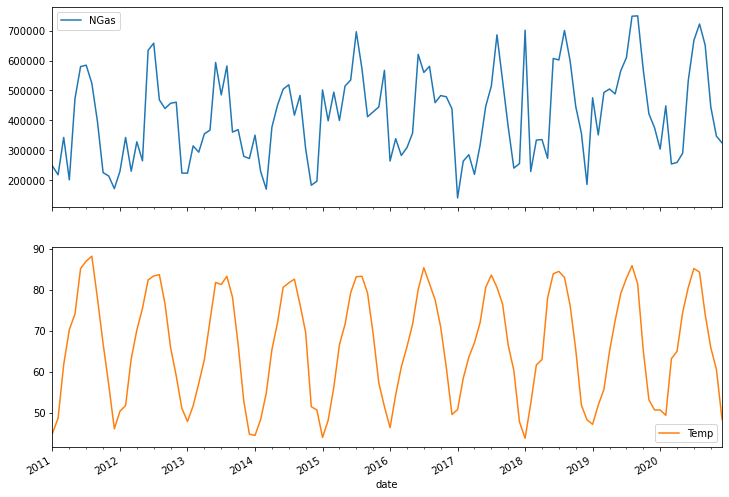

In [15]:
df_full.plot(subplots=True, figsize=(12,9));

In [21]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


In [24]:
df_final=df_full.reset_index()[['date', 'NGas', 'Temp']].rename({'date':'ds','NGas':'y','Temp':'temp'},axis='columns')

In [25]:
df_final

,ds,y,temp
0,2011-01-01,248086.363990,45.0
1,2011-02-01,218819.159530,48.7
2,2011-03-01,343441.973030,61.8
3,2011-04-01,202053.382820,70.3
4,2011-05-01,472446.061500,74.1
...,...,...,...
115,2020-08-01,721716.604984,84.3
116,2020-09-01,651271.628603,74.0
117,2020-10-01,445206.272739,65.9
118,2020-11-01,347772.901358,60.6


In [27]:
df_final['month']=df_final['ds'].dt.month

In [35]:
df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.634777
temp,0.634777,1.000000


In [45]:
train = df_final[(df_final['ds'] >= '2011-01-01') & (df_final['ds'] < '2020-01-01')]
test = df_final[(df_final['ds'] >= '2020-01-01')]

In [47]:
test

,ds,y,temp,month
108,2020-01-01,304592.954092,50.7,1
109,2020-02-01,448682.304718,49.4,2
110,2020-03-01,254899.753223,63.2,3
111,2020-04-01,259930.228185,65.0,4
112,2020-05-01,290880.811913,74.5,5
113,2020-06-01,533865.067901,80.6,6
114,2020-07-01,667294.351428,85.2,7
115,2020-08-01,721716.604984,84.3,8
116,2020-09-01,651271.628603,74.0,9
117,2020-10-01,445206.272739,65.9,10


In [48]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [49]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
m.params

{'k': array([[0.18892982]]),
 'm': array([[0.46117191]]),
 'delta': array([[-3.42894731e-08, -1.24091531e-09, -9.67052068e-10,
         -1.08857285e-08, -2.55469086e-09, -4.78268566e-09,
         -1.27053920e-08, -2.21645625e-08,  4.64875443e-09,
         -4.64716336e-09, -2.70427715e-10,  4.33784307e-10,
          6.72041791e-09, -9.45889541e-09, -4.66005836e-09,
          6.53535610e-09,  5.19882603e-09,  2.65233269e-08,
          3.19873298e-09,  7.69928687e-06, -4.22027366e-10,
          3.07956837e-08, -2.56035356e-08, -4.46440306e-08,
         -7.96191619e-10]]),
 'sigma_obs': array([[0.12878124]]),
 'beta': array([[-3.14549905e-02, -1.79684453e-01,  4.08699555e-03,
          3.55581593e-02,  3.58583347e-03, -2.65772617e-03,
         -6.76516870e-03,  7.70933290e-03,  8.50599195e-03,
          1.38583425e-02, -5.34374130e-03, -8.19452592e-04,
          1.98504706e-03,  2.16943235e-02,  6.63331425e-03,
         -4.73950277e-05, -7.95134532e-03, -1.50878293e-03,
         -2.2500576

In [53]:
future = m.make_future_dataframe(periods=24, freq='MS')
future

,ds
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01
...,...
127,2021-08-01
128,2021-09-01
129,2021-10-01
130,2021-11-01


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2021-08-01,682400.498186,502441.623602,863547.245729
128,2021-09-01,589791.392797,404974.342449,771544.049612
129,2021-10-01,504581.689105,326259.924629,681206.289349
130,2021-11-01,439355.651487,258957.937373,626562.757940
131,2021-12-01,394591.289460,205688.892497,604616.661578


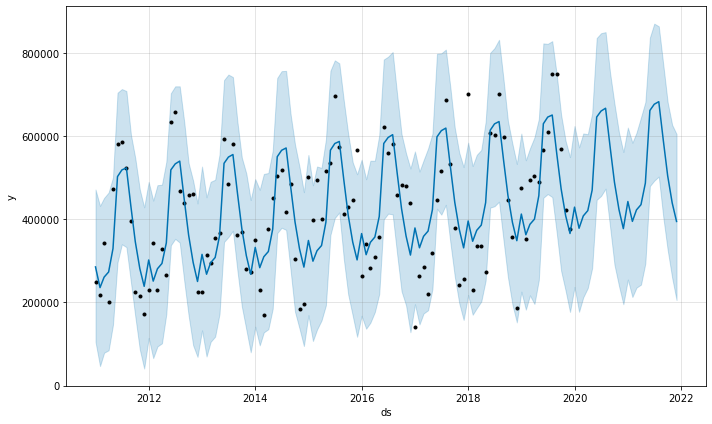

In [57]:
fig1 = m.plot(forecast)

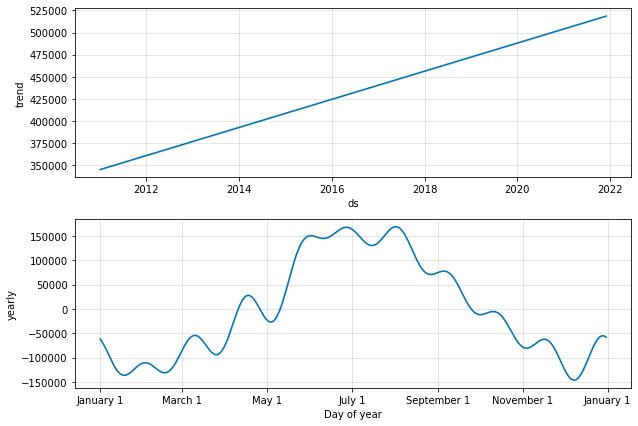

In [58]:
fig2 = m.plot_components(forecast)

### Cross Validation and Performance Metrics

In [72]:
cutoffs

DatetimeIndex(['2012-01-01', '2014-01-01', '2016-01-01', '2018-01-01'], dtype='datetime64[ns]', freq=None)

In [80]:
cutoffs = pd.to_datetime(df_final['ds'].tail(3).values)

In [82]:
cutoffs_1 = cutoffs[:-1]

In [84]:

cv_results = cross_validation(model = m, cutoffs=cutoffs_1, horizon= 365/12)

ValueError: Dataframe has no rows.

In [ ]:
df_p = 

## VAR Time Series Models

In [23]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

## Dickey-Fuller Tests on each Source

### Total

In [35]:
interpret_dftest(adfuller(df['total']))

Test Statistic    -3.656148
p-value            0.004774
Lag Used          29.000000
dtype: float64

In [81]:
interpret_dftest(adfuller(df['total'].diff(1).dropna()))

Test Statistic   -1.692813e+01
p-value           9.823692e-30
Lag Used          2.800000e+01
dtype: float64

In [82]:
df['first_diff_total'] = df['total'].diff(1)

### Biomass

In [24]:
interpret_dftest(adfuller(df['Biomass']))

Test Statistic   -7.435146e+00
p-value           6.211646e-11
Lag Used          2.400000e+01
dtype: float64

### Coal

In [25]:
interpret_dftest(adfuller(df['Coal']))

Test Statistic    -2.877402
p-value            0.048040
Lag Used          29.000000
dtype: float64

In [83]:
interpret_dftest(adfuller(df['Coal'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [85]:
df['first_diff_coal'] = df['Coal'].diff(1)

### Gas

In [26]:
interpret_dftest(adfuller(df['NGas']))

Test Statistic    -4.165856
p-value            0.000752
Lag Used          24.000000
dtype: float64

In [79]:
interpret_dftest(adfuller(df['NGas'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [87]:
df['first_diff_ngas'] = df['NGas'].diff(1)

### Hydro

In [28]:
interpret_dftest(adfuller(df['Hydro']))

Test Statistic    -4.377611
p-value            0.000325
Lag Used          30.000000
dtype: float64

### Nuclear

In [14]:
interpret_dftest(adfuller(df['Nuclear']))

Test Statistic   -2.949252
p-value           0.039913
Lag Used          3.000000
dtype: float64

In [88]:
interpret_dftest(adfuller(df['Nuclear'].diff(1).dropna()))

Test Statistic   -1.480475e+01
p-value           2.073387e-27
Lag Used          3.000000e+01
dtype: float64

In [89]:
df['first_diff_nuclear'] = df['Nuclear'].diff(1)

### Other

In [29]:
interpret_dftest(adfuller(df['Other']))

Test Statistic    -4.578738
p-value            0.000141
Lag Used          30.000000
dtype: float64

### Wind

In [30]:
interpret_dftest(adfuller(df['Wind']))

Test Statistic    -2.681855
p-value            0.077231
Lag Used          28.000000
dtype: float64

In [31]:
# Differenced 
interpret_dftest(adfuller(df['Wind'].diff(1).dropna()))

Test Statistic   -1.804267e+01
p-value           2.654696e-30
Lag Used          3.000000e+01
dtype: float64

#### Because we see a much lower p-value with the differenced data, let's save this column to our dataframe to use in our model

In [37]:
df['first_diff_wind'] = df['Wind'].diff(1)

### Solar

In [32]:
interpret_dftest(adfuller(df['Solar']))

Test Statistic    -1.083391
p-value            0.721650
Lag Used          28.000000
dtype: float64

In [75]:
interpret_dftest(adfuller(df['Solar'].diff(1).dropna()))

Test Statistic   -1.471495e+01
p-value           2.809432e-27
Lag Used          3.000000e+01
dtype: float64

In [76]:
df['first_diff_solar'] = df['Solar'].diff(1)

### Plot ACF & PACF

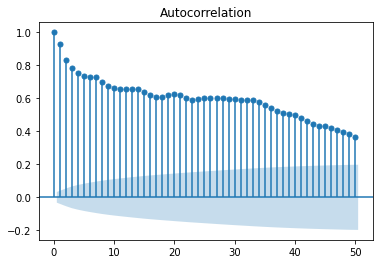

In [33]:
# plot the total electricity acf
plot_acf(df['total'], lags = 50);

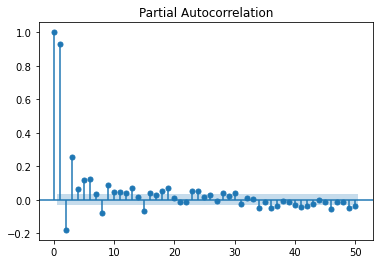

In [36]:
# plot the total electricity pacf
plot_pacf(df['total'], lags = 50);

### Modeling

In [91]:
# Subset our data
model_df = df[['first_diff_total', 'first_diff_ngas', 'first_diff_coal', 'first_diff_wind', 'first_diff_solar', 'first_diff_nuclear']].copy()

# Let's drop rows containing missing data
model_df.dropna(inplace = True)

In [92]:
train, test = train_test_split(model_df,
                              test_size = 0.10, 
                              shuffle=False)

In [93]:
train.head()

,first_diff_total,first_diff_ngas,first_diff_coal,first_diff_wind,first_diff_solar,first_diff_nuclear
date,,,,,,
2011-01-02,-23442.802983,20885.28599,16219.7745,-60681.98976,-60.396132,-54.69529
2011-01-03,-43846.875831,-46686.64013,-24267.4489,26984.17508,4.900669,10.15581
2011-01-04,45045.190080,49462.92700,25778.4140,-29973.08782,-9.877613,-159.68367
2011-01-05,141378.038755,86253.86320,-14078.5576,69378.35680,17.719145,-32.49548
2011-01-06,110739.930548,129772.98138,68316.4110,-87654.82550,43.006927,55.87253


In [94]:
var_model = VAR(train)

/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [95]:
ts_model = var_model.fit(maxlags=5, ic='aic')

In [96]:
# What is the order of our autogressive model?
ts_model.k_ar

5

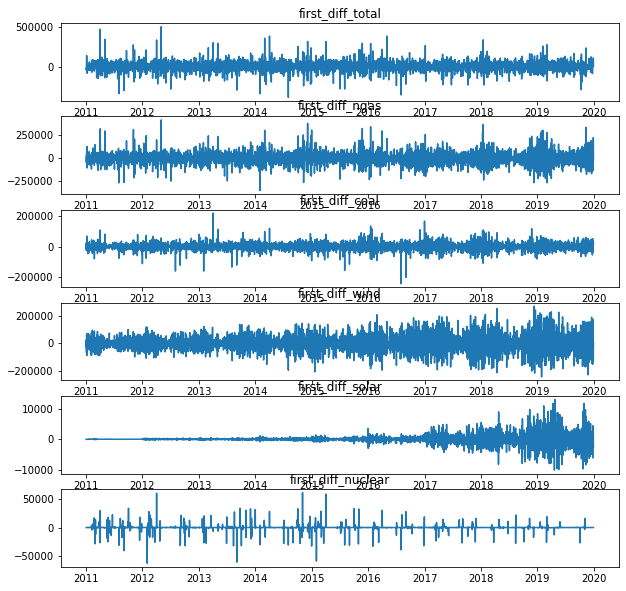

In [97]:
ts_model.plot();

<Figure size 1440x1440 with 0 Axes>

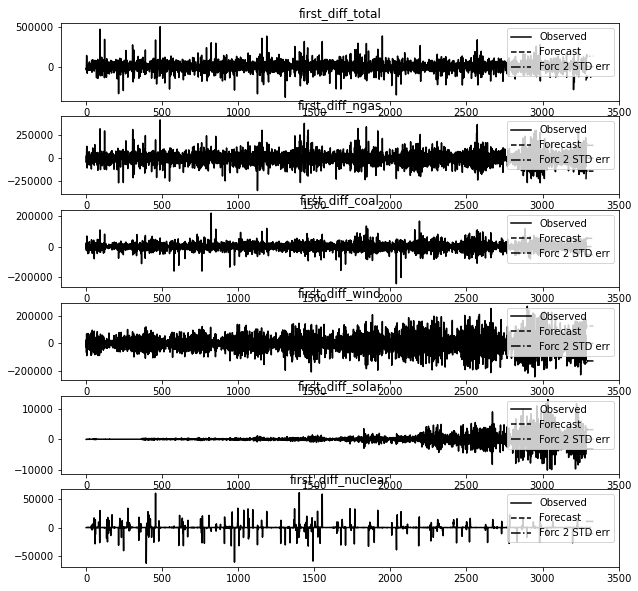

In [98]:
# plot the forecast looking 5 steps ahead
plt.figure(figsize=(20,20))
ts_model.plot_forecast(50);

### Evaluate our models (and forecasts, in possible)

In [99]:
forecast = ts_model.forecast(train.values, len(test))

In [100]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_total data is: 3646963703.8777
The test MSE on the first_diff_ngas data is: 7318147209.5251
The test MSE on the first_diff_coal data is: 481133679.7592
The test MSE on the first_diff_wind data is: 9772181147.9876
The test MSE on the first_diff_solar data is: 54294441.1495
The test MSE on the first_diff_nuclear data is: 9935431.4502


In [101]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the first_diff_total data is: 60390.0961
The test RMSE on the first_diff_ngas data is: 85546.17
The test RMSE on the first_diff_coal data is: 21934.7596
The test RMSE on the first_diff_wind data is: 98854.3431
The test RMSE on the first_diff_solar data is: 7368.4762
The test RMSE on the first_diff_nuclear data is: 3152.0519


### Evaluate our models (and forecasts, in possible)

In [69]:
forecast = ts_model.forecast(train.values, len(test))

In [70]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the total data is: 29577405684.7134
The test MSE on the NGas data is: 23416882833.6194
The test MSE on the Coal data is: 6518154937.4332
The test MSE on the first_diff_wind data is: 9770433458.8709
The test MSE on the Solar data is: 422323163.5973
The test MSE on the Nuclear data is: 182154113.8146


In [71]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the total data is: 171980.8294
The test RMSE on the NGas data is: 153025.7587
The test RMSE on the Coal data is: 80735.0911
The test RMSE on the first_diff_wind data is: 98845.503
The test RMSE on the Solar data is: 20550.5028
The test RMSE on the Nuclear data is: 13496.4482


In [73]:
from autots import AutoTS

